# Deep learning project : Metal surface defects detection

This notebook presents a case study that aims to classify defects on metal surfaces.
To do this we have a dataset of 1800 images of steel surfaces. There are 6 possible defects, so we have 300 images of steel surfaces for each defect.
We started with a sub-dataset of only 90 images: 15 for each defect, dividing the set into two parts:
- training set: 60 images (10 for each defect)
- test set: 30 images (5 for each defect)

In [11]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import os
from torchvision import datasets, transforms, models
from skimage import io, transform
import matplotlib.pyplot as plt
from torch import nn, optim
from time import time

#### Transformations to apply to each image : resize and transformation to tensor

In [2]:
train_trainsforms = transforms.Compose([transforms.Resize((200,200)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,)),])
    
test_trainsforms = transforms.Compose([transforms.Resize((200,200)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5,), (0.5,)),])

## Dataset with 90 images

In [3]:
train_data = datasets.ImageFolder('Data_train/',transform=train_trainsforms)
test_data = datasets.ImageFolder('Data_test/',transform=test_trainsforms)

In [4]:
num_train = len(train_data)                               
indices = list(range(num_train))   

In [5]:
num_test = len(test_data)                              
indices = list(range(num_test))

The loader will load each time 32 images for one training iteration and we set a seed to have always the same random batches.

In [6]:
torch.manual_seed(2)
train_loader =  torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True)

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:,0,:,:]
print(images.shape)
print(labels.shape)



torch.Size([32, 200, 200])
torch.Size([32])


All images are square and are made up of 40000 pixels (200 x 200)

Printing the labels of a batch as a result we get labels with numbers in a range between 0 and 5, as there are 6 defects identified by numbers.
The defects corresponding to the various numbers are:
- 0: Crazing
- 1: Inclusions
- 2: Patches
- 3: Pitted Surface
- 4: Rolled in Scale
- 5: Scratches

In [9]:
print(labels)

tensor([0, 1, 0, 4, 3, 3, 3, 3, 5, 2, 3, 5, 2, 3, 5, 1, 5, 5, 1, 5, 1, 4, 0, 2,
        4, 5, 1, 0, 0, 2, 2, 1])


Here is the print of the first image of the batch.

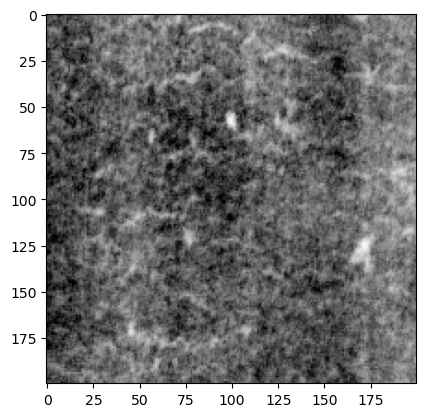

In [10]:
plt.imshow(images[0], cmap='gray_r');

Here is the plot of a big part of the batch.

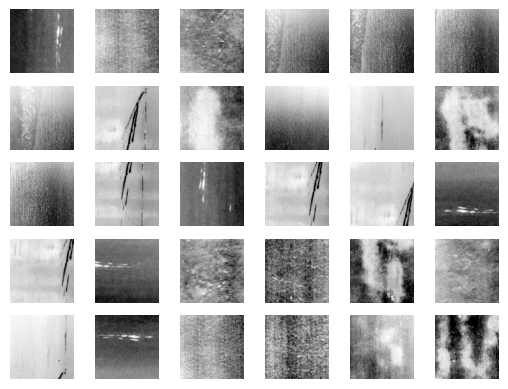

In [11]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images+1):
    plt.subplot(5, 6, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

We create our own neural network model:
since the image has already been transformed into a tensor, it has already been flattened, so in theory the input layer should consist of 40000 neurons (200x200). However, since our images are considered in colour, they have to pass through 3 filters (RGB) and therefore the input layer is composed of 120,000 neurons (40000x3).
The output layer must be made up of 6 neurons because there are 6 possible metal defects.
We have decided to create 2 hidden layers with 128 and 64 neurons each.

Each Neuron from the Hidden Layer is implemented with a ReLu activation function and the output layer with a LogSoftmax. This architecture is better suited for Convolutional Neural Network which is the reference for image processing.



In [12]:
input_size = 120000

hidden_sizes = [128,64]
output_size = 6

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=120000, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=6, bias=True)
  (5): LogSoftmax(dim=1)
)


We opt for a the negative log likelihood loss. It is useful to train a classification problem with C classes.

In [13]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))

images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

The image tensor consists of 32 images (batch size) and therefore 32 rows and 120000 columns (number of pixels in each image multiplied by 3 because of the 3 RGB filters).

In [14]:
images.shape

torch.Size([32, 120000])

We now apply backward propagation to improve the weights and lower the cost function.

In [15]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)



Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.0712e-04,  3.4287e-04,  4.1095e-04,  ..., -1.0016e-03,
         -1.0953e-03, -1.0570e-03],
        [ 2.8127e-04,  2.1198e-04,  3.3812e-04,  ...,  1.3772e-03,
          1.1965e-03,  1.2001e-03],
        [ 2.3716e-04,  2.6749e-04,  5.8583e-04,  ...,  8.9074e-04,
          1.0515e-03,  1.3305e-03],
        ...,
        [ 1.1394e-03,  1.0645e-03,  8.6327e-04,  ..., -1.9270e-03,
         -1.7084e-03, -1.6297e-03],
        [ 6.9813e-04,  5.6728e-04,  5.9704e-04,  ..., -3.9084e-05,
         -1.0187e-04, -1.3337e-04],
        [ 5.9797e-04,  5.1434e-04,  6.4209e-04,  ...,  1.4399e-04,
          4.1081e-04,  5.4685e-04]])


Using the stochastic gradient descent optimiser, we try to achieve a good accuracy score by making 20 epochs (as the Gradient Descent is an iterative process and updating the weights with single pass or one epoch is not enough).
We set again the seed to have always the same results.

In [16]:
torch.manual_seed(2)
#the Stochastic Gradient Descent optimizer
#momentum is a parameter that will avoid us getting stuck into a local minimum : a value between 0 and 1
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
#number of feedforward and backpropagation iterations that we will do to train the network
epochs = 20
for e in range(epochs):
    #we start with an error or loss of zero
    running_loss = 0
    
    #Iteration through the images dataset
    for images, labels in train_loader:
        
        # Flatten images into a long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.7896192073822021
Epoch 1 - Training loss: 1.724358856678009
Epoch 2 - Training loss: 1.6255897283554077
Epoch 3 - Training loss: 1.5177350640296936
Epoch 4 - Training loss: 1.3738736510276794
Epoch 5 - Training loss: 1.2326921820640564
Epoch 6 - Training loss: 1.1124187707901
Epoch 7 - Training loss: 1.00307297706604
Epoch 8 - Training loss: 0.9068714380264282
Epoch 9 - Training loss: 0.8086752891540527
Epoch 10 - Training loss: 0.7338437139987946
Epoch 11 - Training loss: 0.6606720089912415
Epoch 12 - Training loss: 0.6035723686218262
Epoch 13 - Training loss: 0.5458540320396423
Epoch 14 - Training loss: 0.49299778044223785
Epoch 15 - Training loss: 0.4431847929954529
Epoch 16 - Training loss: 0.41463616490364075
Epoch 17 - Training loss: 0.375057190656662
Epoch 18 - Training loss: 0.33916623890399933
Epoch 19 - Training loss: 0.31458868086338043

Training Time (in minutes) = 0.11328898668289185


The time to complete the operation is very low even though there are so many neurons because in this case the dataset is only 90 images.

In [17]:
for images, labels in train_loader:
    print(images.shape)

torch.Size([32, 3, 200, 200])
torch.Size([28, 3, 200, 200])


In [18]:
torch.manual_seed(2)
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 120000)
    #torch.no_grad(): Context-manager that disabled gradient calculation
    with torch.no_grad():
        logps = model(img)

    #get the scores obtained for each class. 
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    
    #choose the one having the maximum score and compare it to the real label
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nNumber of images predicted correctly =", correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 30

Number of images predicted correctly = 15

Model Accuracy = 0.5


By training our neural network we had an accuracy score of our model of 57%. This means that out of 30 images in our test set, our model correctly classified the defect on the metal in 57% of the cases (i.e. 17 out of 30 images).

## Dataset with 1800 images

Not being a very high score, we try in the second part of the notebook to enlarge the dataset from 90 images to 1800. 
Moreover in the previous dataset the test set was 33.3% of the total dataset, while the dataset of 1800 images is separated in this way:
- 1620 images in the training set (90%)
- 180 images in the test set (10%)

In [19]:
train_data= datasets.ImageFolder('New_data_train/',transform=train_trainsforms)
test_data = datasets.ImageFolder('New_data_test/',transform=test_trainsforms)

In [20]:
num_train = len(train_data)                               
indices = list(range(num_train))   

In [21]:
num_test = len(test_data)                               
indices = list(range(num_test))

Again, the batch size chosen is 32 images.

In [22]:
torch.manual_seed(9)
train_loader =  torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True)

In [24]:
#print the size of the data
#the first line prints the size of the images tensor : There are 64 images in a batch and each image has 200 x 2000 pixels
#as we have RGB images the first dimension of the image is 3 and not 1

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:,0,:,:]
print(images.shape)
print(labels.shape)



torch.Size([32, 200, 200])
torch.Size([32])


In [25]:
#we have 6 classes corresponding to 6 types of defects
#the loader will code these classes from 0 to 5
print(labels)

tensor([0, 0, 1, 2, 2, 1, 2, 3, 1, 0, 3, 0, 0, 4, 3, 2, 4, 1, 5, 1, 5, 2, 5, 5,
        3, 4, 3, 2, 0, 5, 3, 5])


In [26]:
#depth, width, height
images[1].numpy().shape

(200, 200)

In order to increase the final accuracy of the model we have tried an heavier NN architecture with 4 hidden layers (512, 256, 128, 64 respectively).

![NN Representation](nn2.png)

In [27]:
input_size = 120000

hidden_sizes = [512,256,128,64]
output_size = 6

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=120000, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=6, bias=True)
  (9): LogSoftmax(dim=1)
)


In [28]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))

#view(a, b)` will return a new tensor with the same data as `images` with size `(a, b)`.
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities, the output of our neural network model
loss = criterion(logps, labels) #calculate the NLL loss

In [29]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)



Before backward pass: 
 None
After backward pass: 
 tensor([[ 7.9777e-05,  6.6101e-05,  6.7507e-05,  ..., -4.3729e-05,
         -3.8780e-05, -1.7641e-05],
        [-1.7818e-04, -1.7899e-04, -1.7952e-04,  ..., -7.2432e-05,
         -5.4951e-05, -6.7139e-05],
        [-2.7058e-04, -2.5259e-04, -2.7949e-04,  ..., -2.3766e-04,
         -2.5222e-04, -2.7893e-04],
        ...,
        [-8.8242e-05, -8.5178e-05, -1.0696e-04,  ..., -3.6679e-05,
         -4.5720e-05, -3.9669e-05],
        [ 5.5474e-06,  3.7893e-06,  8.6968e-06,  ..., -6.4605e-05,
         -7.3997e-05, -8.6766e-05],
        [ 1.9843e-04,  1.3927e-04,  1.8788e-04,  ...,  4.2119e-05,
          5.7989e-05,  6.6994e-05]])


In [30]:
#the Stochastic Gradient Descent optimizer
#momentum is a parameter that will avoid us getting stuck into a local minimum : a value between 0 and 1
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
torch.manual_seed(9)

#number of feedforward and backpropagation iterations that we will do to train the network
epochs = 20
for e in range(epochs):
    #we start with an error or loss of zero
    running_loss = 0
    
    #Iteration through the images dataset
    for images, labels in train_loader:
        
        # Flatten images into a long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.69752598510069
Epoch 1 - Training loss: 1.5442102282655006
Epoch 2 - Training loss: 1.4104012648264568
Epoch 3 - Training loss: 1.2620347259091396
Epoch 4 - Training loss: 1.137041169054368
Epoch 5 - Training loss: 1.0549938059320636
Epoch 6 - Training loss: 1.0078250111318101
Epoch 7 - Training loss: 0.9282920173570222
Epoch 8 - Training loss: 0.8622300268388262
Epoch 9 - Training loss: 0.7624282644075506
Epoch 10 - Training loss: 0.6984356881356707
Epoch 11 - Training loss: 0.6677214731188381
Epoch 12 - Training loss: 0.5770188196032655
Epoch 13 - Training loss: 0.5551290278341255
Epoch 14 - Training loss: 0.5859324832757314
Epoch 15 - Training loss: 0.5234237593763015
Epoch 16 - Training loss: 0.4485731081050985
Epoch 17 - Training loss: 0.40623244701647293
Epoch 18 - Training loss: 0.4380515206093882
Epoch 19 - Training loss: 0.363893232217022

Training Time (in minutes) = 6.87630633910497


The time in this case is much higher (about 5 minutes) due to both the much larger dataset and the addition of 2 hidden layers compared to the previous model.

In [31]:
torch.manual_seed(9)
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 120000)
    #torch.no_grad(): Context-manager that disabled gradient calculation
    with torch.no_grad():
        logps = model(img)

    #get the scores obtained for each class. 
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    
    #choose the one having the maximum score and compare it to the real label
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nNumber of images predicted correctly =", correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 180

Number of images predicted correctly = 88

Model Accuracy = 0.4888888888888889


With the larger dataset we managed to get a higher accuracy score: 64%. This means that out of the 180 images in the test set, the model got the metal default right in 115 images.

Let's test one image prediction from the test set

In [32]:
torch.manual_seed(1)
images, labels = next(iter(test_loader))
image = images[0]
label = labels[0]

img = image.view(1, 120000)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted metal surface defect =", probab.index(max(probab)))
print("Label =", labels[0])

Predicted metal surface defect = 1
Label = tensor(1)


This image was correctly predicted: in fact it is an inclusion defect (type 1) and our neural network gave the correct defect as a prediction.

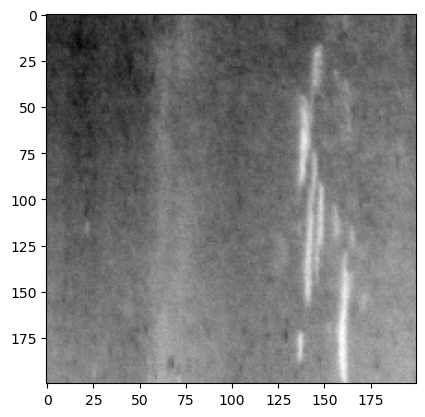

In [33]:
image = image[0]
plt.imshow(image, cmap='gray_r');

## Test on a random unlabeled image

In this last part we take an image from the validation set: i.e. an unlabelled image that our model has never seen, to see if it can correctly predict the type of defect.

In [34]:
val_trainsforms = transforms.Compose([transforms.Resize((200,200)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5,), (0.5,)),])

In [35]:
val_data = datasets.ImageFolder('Data_validation/',transform=val_trainsforms)

In [36]:
val_loader =  torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=True)

In [37]:
torch.manual_seed(2)
images, labels = next(iter(val_loader))
image = images[0]

img = image.view(1, 120000)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Defect =", probab.index(max(probab)))

Predicted Defect = 1


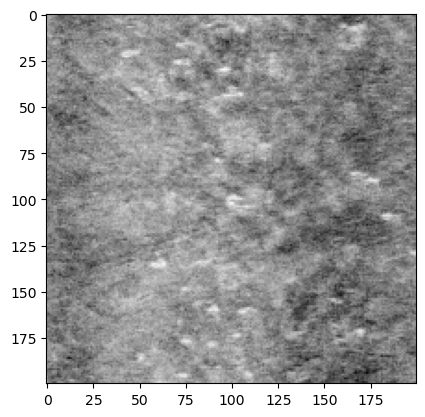

In [38]:
image = image[0]
plt.imshow(image, cmap='gray_r');

Of this image, we do not have the label, but comparing by eye with the images representing a defect of type scratches (type 5), it seems that our model correctly predicted this image coming out of the dataset without the labels as well.

## Possible business use case

This algorithm is useful in order to revamp the production part of the value-chain of a company. In fact, this model associated to a visual sensor could help to improve quality on the production line of a steel company. The line detects an anomaly on the steel layer and an operator or another robotisation can remove the steel layer from the line. This system exists already in the automotive and aeronautic industry where robots empowered by computer vision are doing the checkup of the pieces in order to validate its quality and lower error rate.